# Actividad: Regresión Lineal y KMeans

Objetivo: practicar el flujo de Business Analytics con aprendizaje supervisado (regresión lineal) y no supervisado (KMeans).

## 1) Preparación
Cargamos librerías y el dataset `casas.csv`

In [26]:
%matplotlib inline
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')
csv_path = 'inmuebles_bogota.csv'
df = pd.read_csv(csv_path)

# Data Cleaning and Renaming
df = df.rename(columns={'Área': 'Area', 'Valor': 'Precio'})
df['Precio'] = df['Precio'].str.replace('[$\.,]', '', regex=True).astype(float)
df = df.drop('Baños', axis=1)

# Format the 'Precio' column for display
pd.options.display.float_format = '{:,.2f}'.format

display(df.head())
print('Filas:', len(df), '| Columnas:', list(df.columns))

,Tipo,Descripcion,Habitaciones,Area,Barrio,UPZ,Precio
0,Apartamento,Apartamento en venta en Zona Noroccidental,3,70,Zona Noroccidental,CHAPINERO: Pardo Rubio + Chapinero,"360,000,000.00"
1,Casa,Casa en venta en Castilla,4,170,Castilla,KENNEDY: Castilla + Bavaria,"670,000,000.00"
2,Apartamento,Apartamento en venta en Chico Reservado,3,144,Chico Reservado,CHAPINERO: Chicó Lago + El Refugio,"1,120,000,000.00"
3,Apartamento,Apartamento en venta en Usaquén,3,154,Usaquén,Usaquén,"890,000,000.00"
4,Apartamento,Apartamento en venta en Bella Suiza,2,128,Bella Suiza,USAQUÉN: Country Club + Santa Bárbara,"970,000,000.00"


Filas: 9520 | Columnas: ['Tipo', 'Descripcion', 'Habitaciones', 'Area', 'Barrio', 'UPZ', 'Precio']


## 2) EDA (Exploración de Datos)
Objetivo: conocer estructura, valores típicos y relaciones.

In [53]:
# Display descriptive statistics, formatting Habitaciones as integer
desc_df = df.describe()
desc_df['Habitaciones'] = desc_df['Habitaciones'].astype(int)
display(desc_df)

df.info()

,Habitaciones,Area,Precio
count,9368,"9,368.00","9,368.00"
mean,2,111.92,"566,495,779.06"
std,1,85.70,"587,598,002.70"
min,1,15.00,"60,000,000.00"
25%,2,57.00,"250,000,000.00"
50%,3,80.00,"400,000,000.00"
75%,3,130.00,"651,250,000.00"
max,20,498.00,"10,451,500,000.00"


<class 'pandas.core.frame.DataFrame'>
Index: 9368 entries, 0 to 9519
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tipo          9368 non-null   object 
 1   Descripcion   9368 non-null   object 
 2   Habitaciones  9368 non-null   int64  
 3   Area          9368 non-null   int64  
 4   Barrio        9368 non-null   object 
 5   UPZ           9326 non-null   object 
 6   Precio        9368 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 585.5+ KB


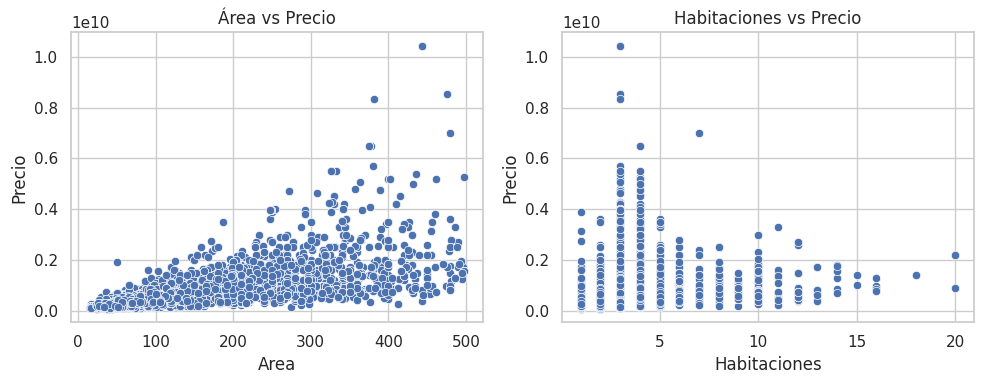

In [54]:
# Filter out properties with Area less than or equal to 10 sq meters, the extreme Area outlier, and properties with more than 20 bedrooms
df = df[(df['Area'] > 10) & (df['Area'] < 500) & (df['Habitaciones'] <= 20)].copy()

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.scatterplot(ax=axes[0], x='Area', y='Precio', data=df)
axes[0].set_title('Área vs Precio')
sns.scatterplot(ax=axes[1], x='Habitaciones', y='Precio', data=df)
axes[1].set_title('Habitaciones vs Precio')
plt.tight_layout(); plt.show()

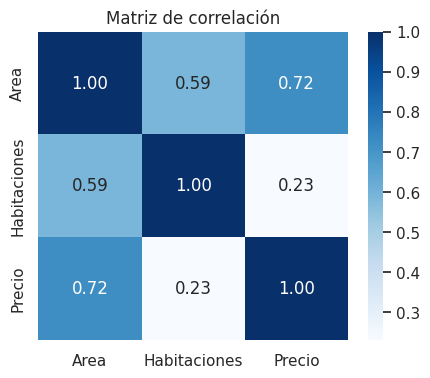

In [55]:
plt.figure(figsize=(5,4))
sns.heatmap(df[['Area','Habitaciones','Precio']].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Matriz de correlación'); plt.show()

## 3) Aprendizaje Supervisado: Regresión Lineal
Definimos features y target, entrenamos, calculamos métricas y analizamos gráficos de diagnóstico.

R2: 0.5605
MAE: 170,162,809.93
MSE: 159,138,489,446,106,624.00
RMSE: 398,921,658.28
Coeficientes (Area, Habitaciones): [ 6.04871378e+06 -1.05180745e+08]
Intercepto: 204,579,657.36


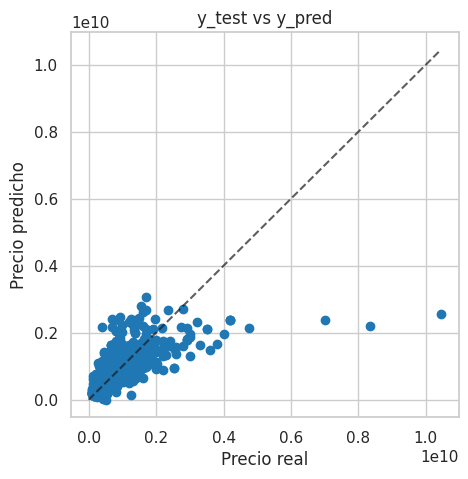

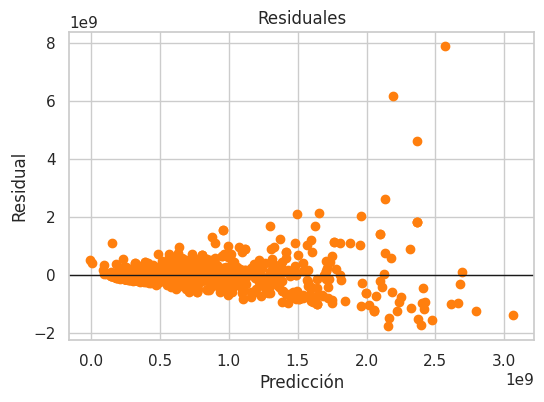

In [56]:
X = df[['Area','Habitaciones']]
y = df['Precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R2: {r2:.4f}')
print(f'MAE: {mae:,.2f}')
print(f'MSE: {mse:,.2f}')
print(f'RMSE: {rmse:,.2f}')
print('Coeficientes (Area, Habitaciones):', model.coef_)
print('Intercepto:', f'{model.intercept_:,.2f}')

# y_test vs y_pred
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, color='tab:blue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', alpha=0.7)
plt.xlabel('Precio real'); plt.ylabel('Precio predicho'); plt.title('y_test vs y_pred')
plt.show()

# Residuales
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.axhline(0, color='k', lw=1)
plt.scatter(y_pred, residuals, color='tab:orange')
plt.xlabel('Predicción'); plt.ylabel('Residual'); plt.title('Residuales')
plt.show()


## 4) Aprendizaje No Supervisado: KMeans
Estandarizamos features, probamos varios `k` y elegimos según `silhouette`. Luego ajustamos el modelo y analizamos clusters y centroides.

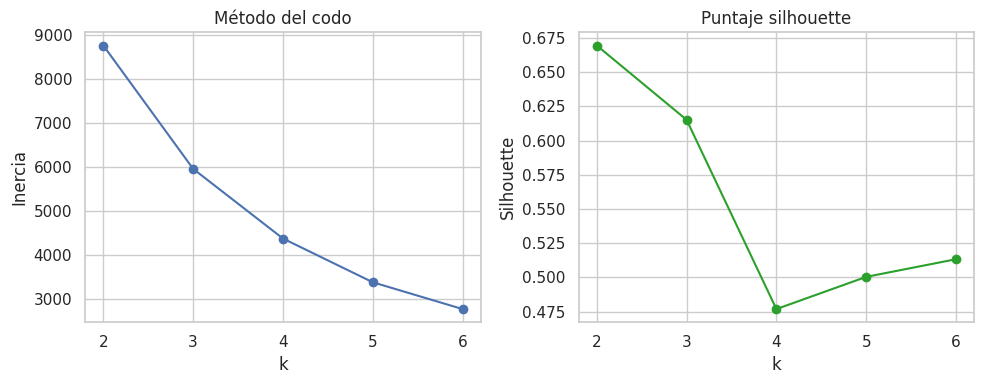

Mejor k por silhouette: 2


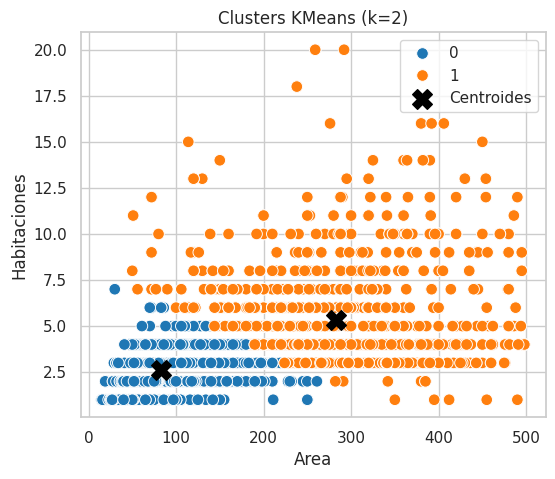

,cluster,Area,Habitaciones,Precio
0,0,82.87,2.60,"434,206,429.11"
1,1,282.68,5.32,"1,344,108,507.20"


In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ks = list(range(2, min(7, len(df))))
inertias, silhouettes = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(ks, inertias, marker='o'); axes[0].set_title('Método del codo')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inercia')
axes[1].plot(ks, silhouettes, marker='o', color='tab:green'); axes[1].set_title('Puntaje silhouette')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette')
plt.tight_layout(); plt.show()

best_k = ks[int(np.argmax(silhouettes))]
print('Mejor k por silhouette:', best_k)
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df_clusters = df.copy(); df_clusters['cluster'] = labels
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=['Area','Habitaciones'])

plt.figure(figsize=(6,5))
sns.scatterplot(x='Area', y='Habitaciones', hue='cluster', data=df_clusters, palette='tab10', s=70)
plt.scatter(centroids_df['Area'], centroids_df['Habitaciones'], s=200, c='black', marker='X', label='Centroides')
plt.title(f'Clusters KMeans (k={best_k})'); plt.legend(); plt.show()

profile = df_clusters.groupby('cluster')[['Area','Habitaciones','Precio']].mean().reset_index()
display(profile)


## 5) Lectura de Gráficas (Guía rápida)
- Área vs Precio: ascenso indica relación positiva; nube alineada sugiere linealidad.
- Habitaciones vs Precio: tendencia ascendente por discreción de habitaciones.
- Correlación: valores cercanos a 1 indican asociación lineal fuerte.
- y_test vs y_pred: puntos cerca de la diagonal implican buenas predicciones.
- Residuales: nube centrada en 0 sin patrón sugiere supuestos razonables.
- Codo: elegir k donde la caída de inercia se estabiliza.
- Silhouette: mayor es mejor separación/cohesión de clusters.
- Clusters: colores muestran grupos; X negras son centroides (perfiles promedio).